# FederPy를 이용한 시각화 - trial1

In [38]:
# import
from federpy.federpy import FederPy


### Data Preparation

In [13]:
# index file built by hnswlib or faiss.
hnswSource = 'hnswlib'
# import index file at ./index/
base_path = "./index"
clustered_hnsw_index_path = base_path + "/clustered_hnsw_index.index"
clustered_rr_index_path = base_path + "/clustered_rr_index.index"
naive_hnsw_index_path = base_path + "/naive_hnsw_index.index"

### Search View

## Vis for HNSW (hnswlib)

In [14]:
# init federpy
hnswViewParams = {
    "width": 800,
    "height": 500,
#     "mediaType": "image",
#     "mediaUrls": imageUrls
}
federPy_hnsw = FederPy(
    naive_hnsw_index_path, hnswSource, [],  **hnswViewParams)

NameError: name 'FederPy' is not defined

### Overview

### Search View

In [46]:
federPy_hnsw.setSearchParams({"k": 10, "ef": 8}).searchById(4)

In [47]:
federPy_hnsw_clustered = FederPy(
    clustered_rr_index_path, hnswSource, [],  **hnswViewParams)
federPy_hnsw_clustered.setSearchParams({"k": 10, "ef": 8}).searchById(4)

# umap-learn - trial2

In [72]:
import numpy as np
import hnswlib
import umap
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.cluster import KMeans
import h5py
import struct

def read_fvecs(filename):
    """Reads .fvecs binary file into np.ndarray of shape (n, d)."""
    with open(filename, 'rb') as f:
        data = f.read()
    dim = struct.unpack('i', data[:4])[0]
    vecs = np.frombuffer(data, dtype=np.float32)
    vecs = vecs.reshape(-1, dim + 1)[:, 1:]  # drop the leading 'dim'
    return vecs


def read_ivecs(filename):
    """Reads .ivecs binary file into np.ndarray of shape (n, k)."""
    with open(filename, 'rb') as f:
        data = f.read()
    dim = struct.unpack('i', data[:4])[0]
    vecs = np.frombuffer(data, dtype=np.int32)
    vecs = vecs.reshape(-1, dim + 1)[:, 1:]
    return vecs

# 데이터셋 경로 (현재 구조에 맞춰 수정)
base_path = "./datasets"
# 데이터셋 경로
file_path = base_path + "/glove-200-angular.hdf5"

# h5py를 사용하여 파일 열기
with h5py.File(file_path, 'r') as f:
    # HDF5 파일 내의 데이터셋 키 확인 (어떤 데이터가 있는지 모를 경우 유용)
    print(f"Keys in HDF5 file: {list(f.keys())}")

    # 각 데이터셋을 numpy 배열로 불러오기
    train = np.array(f['train'])
    test = np.array(f['test'])
    neighbors = np.array(f['neighbors'])
    # distances 데이터셋이 있다면 같이 로드할 수 있습니다.
    # distances = np.array(f['distances'])

# random sample 100,000 from train
seed = 42
n_target = 10_000
rng = np.random.RandomState(seed)
idx = rng.choice(train.shape[0], n_target, replace=False)
train = train[idx]

dim = train.shape[1]
efConstruction = 400
paramM = 4
distance_method = 'cosine'

def build_hnsw_index(order, M=16, efc=200, space='l2'):
    """Build an hnswlib index by adding items in a specific order. ids are original indices."""
    p = hnswlib.Index(space=space, dim=dim)
    p.init_index(max_elements=len(train), ef_construction=efc, M=M)
    # add in batches to keep order while being efficient
    B = 20000
    total_added = 0
    for s in range(0, len(order), B):
        chunk_idx = order[s:s+B]
        print(f"Adding batch: {s} to {s+len(chunk_idx)} (total so far: {total_added})")
        p.add_items(train[chunk_idx], ids=np.array(chunk_idx, dtype=np.int32))
        total_added += len(chunk_idx)
        print(f"Finished adding batch: {s} to {s+len(chunk_idx)} (total added: {total_added})")
    return p

K_value = 10

# ---- Build indices with hnswlib (order matters via add_items batching) ----
# 1) naive(random) insertion order
print("Building naive/random order index ...")
rng_global = np.random.default_rng(42)
naive_order = rng_global.permutation(len(train)).tolist()
naive_index = build_hnsw_index(naive_order, M=paramM, efc=efConstruction, space=distance_method)

# 2) k-means clustering to derive clustered orders
kmeans = KMeans(n_clusters=500, n_init='auto', random_state=21).fit(train)
labels = kmeans.labels_
cluster_data = defaultdict(list)
for i, lbl in enumerate(labels):
    cluster_data[int(lbl)].append(i)

# 2-1) strict clustered order (cluster by cluster)
print("Building clustered order index ...")
clustered_order = []
for c in sorted(cluster_data.keys()):
    clustered_order.extend(cluster_data[c])
clustered_index = build_hnsw_index(clustered_order, M=paramM, efc=efConstruction, space=distance_method)

# 2-2) round-robin across clusters
print("Building clustered round-robin order index ...")
max_len = max(len(v) for v in cluster_data.values())
rr_order = []
for j in range(max_len):
    for c in sorted(cluster_data.keys()):
        if j < len(cluster_data[c]):
            rr_order.append(cluster_data[c][j])
clustered_rr_index = build_hnsw_index(rr_order, M=paramM, efc=efConstruction, space=distance_method)

# --- 4. UMAP으로 2D 차원 축소 (시각화 레이아웃 생성) ---
# HNSW와 동일한 메트릭(cosine)을 사용해야 의미가 통합니다.
print("Running UMAP for 2D layout...")

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,    # UMAP이 참고할 이웃 수 (HNSW의 M과 다름)
    min_dist=0.1,      # 점들 사이의 최소 거리
    metric=distance_method, # HNSW와 동일한 메트릭 사용
    random_state=42
)
embedding_2d = reducer.fit_transform(train)

print(f"UMAP embedding shape: {embedding_2d.shape}") # (10000, 2)

# --- 5. HNSW Layer 0의 모든 엣지 추출 ---
# hnswlib의 .get_neighbors(id)는 Layer 0의 이웃을 반환합니다.
print("Extracting Layer 0 edges...")
edge_list = []
for i in range(n_target):
    # i번째 노드의 Layer 0 이웃들을 가져옴
    neighbors = naive_index.get_neighbors(i)

    for neighbor_id in neighbors:
        # (시작점, 끝점) 튜플을 리스트에 추가
        edge_list.append((i, neighbor_id))

print(f"Extracted {len(edge_list)} edges.")

# --- 6. 시각화 (UMAP 좌표 위에 엣지 겹쳐 그리기) ---
print("Plotting graph... (This may take a moment)")
plt.figure(figsize=(12, 12))

# 엣지를 효율적으로 그리기 위해 LineCollection 사용
# UMAP 좌표를 기반으로 엣지 세그먼트 생성
segments = []
for start_node, end_node in edge_list:
    segments.append([
        embedding_2d[start_node], # 시작점의 2D 좌표
        embedding_2d[end_node]    # 끝점의 2D 좌표
    ])

# zorder=1: 엣지를 점보다 아래에 그림
lc = LineCollection(segments, colors='gray', alpha=0.1, zorder=1)
ax = plt.gca()
ax.add_collection(lc)

# UMAP 2D 좌표에 점(노드) 그리기
# zorder=2: 점을 엣지보다 위에 그림
plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    s=1,  # 점 크기
    c='blue', # 점 색상
    alpha=0.5,
    zorder=2
)

plt.title(f"HNSW Layer 0 Graph (M={paramM}) on UMAP Layout (N={n_target})")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.axis('equal') # X, Y 축 스케일을 동일하게
plt.show()

Keys in HDF5 file: ['distances', 'neighbors', 'test', 'train']
Building naive/random order index ...
Adding batch: 0 to 10000 (total so far: 0)
Finished adding batch: 0 to 10000 (total added: 10000)
Building clustered order index ...
Adding batch: 0 to 10000 (total so far: 0)
Finished adding batch: 0 to 10000 (total added: 10000)
Building clustered round-robin order index ...
Adding batch: 0 to 10000 (total so far: 0)
Finished adding batch: 0 to 10000 (total added: 10000)
Running UMAP for 2D layout...


/opt/anaconda3/envs/venv/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (10000, 2)
Extracting Layer 0 edges...


AttributeError: 'hnswlib.Index' object has no attribute 'get_neighbors'

## UMP trial2 with faiss

In [4]:
import faiss  # hnswlib 대신 faiss 임포트
import numpy as np
import umap
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.cluster import KMeans
import h5py
import struct
from collections import defaultdict  # cluster-wise order에 필요

def read_fvecs(filename):
    """Reads .fvecs binary file into np.ndarray of shape (n, d)."""
    with open(filename, 'rb') as f:
        data = f.read()
    dim = struct.unpack('i', data[:4])[0]
    vecs = np.frombuffer(data, dtype=np.float32)
    vecs = vecs.reshape(-1, dim + 1)[:, 1:]  # drop the leading 'dim'
    return vecs

def read_ivecs(filename):
    """Reads .ivecs binary file into np.ndarray of shape (n, k)."""
    with open(filename, 'rb') as f:
        data = f.read()
    dim = struct.unpack('i', data[:4])[0]
    vecs = np.frombuffer(data, dtype=np.int32)
    vecs = vecs.reshape(-1, dim + 1)[:, 1:]
    return vecs

# 데이터셋 경로 (현재 구조에 맞춰 수정)
base_path = "./datasets"
# 데이터셋 경로
file_path = base_path + "/glove-200-angular.hdf5"

# h5py를 사용하여 파일 열기
with h5py.File(file_path, 'r') as f:
    # HDF5 파일 내의 데이터셋 키 확인 (어떤 데이터가 있는지 모를 경우 유용)
    print(f"Keys in HDF5 file: {list(f.keys())}")

    # 각 데이터셋을 numpy 배열로 불러오기
    train = np.array(f['train'])
    test = np.array(f['test'])
    neighbors = np.array(f['neighbors'])
    # distances 데이터셋이 있다면 같이 로드할 수 있습니다.
    # distances = np.array(f['distances'])

# random sample 100,000 from train
seed = 42
n_target = 10_000
rng = np.random.RandomState(seed)
idx = rng.choice(train.shape[0], n_target, replace=False)
train = train[idx]

dim = train.shape[1]
efConstruction = 40
paramM = 4
distance_method = 'cosine'

# --- 3. Naive vs Cluster-wise: 두 인덱스 빌드 & 시각화 ---
print("Building Faiss HNSW (naive vs cluster-wise) ...")

# (1) Cosine ~= Inner Product 를 위해 L2 정규화
train_norm = train.copy()
faiss.normalize_L2(train_norm)

# (2) 하나의 공통 UMAP 레이아웃(공정 비교)
print("Running UMAP for 2D layout...")
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric=distance_method,   # 'cosine'
    random_state=42
)
embedding_2d = reducer.fit_transform(train_norm)  # (N, 2)

def build_faiss_hnsw_index(vectors, order, M, efc):
    """지정한 삽입 순서(order)로 HNSW 인덱스를 빌드."""
    index = faiss.IndexHNSWFlat(dim, M, faiss.METRIC_INNER_PRODUCT)
    index.hnsw.efConstruction = efc
    index.add(vectors[order])  # 순서대로 add
    return index

# 쿼리를 아예 제외하고 생각해야함
def extract_layer0_edges(hnsw_index):
    """Faiss HNSW의 layer-0 엣지(인접리스트) 추출."""
    offsets = faiss.vector_to_array(hnsw_index.hnsw.offsets)
    neighbors_flat = faiss.vector_to_array(hnsw_index.hnsw.neighbors)

    edges = []
    for i in range(len(offsets) - 1):
        s, e = offsets[i], offsets[i + 1]
        for nb in neighbors_flat[s:e]:
            if nb >= 0:
                edges.append((i, int(nb)))
    return edges

def to_edge_set_in_original_ids(edges, order):
    """
    hnsw 내부 id로 표현된 edges 를 '원본 샘플 id' 쌍(무방향, 정렬된 튜플)으로 변환해 set으로 반환.
    - edges: [(u_internal, v_internal), ...]
    - order: 내부 id -> 원본 id 로의 매핑을 담은 배열(naive_order / clustered_order)
    """
    order = np.asarray(order)
    s = set()
    for u, v in edges:
        ou = int(order[u]); ov = int(order[v])
        if ou == ov:
            continue
        # 무방향(edge 중복 제거)을 위해 정렬된 튜플로 저장
        if ou < ov:
            s.add((ou, ov))
        else:
            s.add((ov, ou))
    return s

def filter_by_umap_length(edge_set, coords, threshold=None):
    """
    UMAP 상에서 일정 길이(threshold) 이상인 엣지만 남기고 싶을 때 사용.
    threshold가 None이면 필터링 하지 않음.
    - edge_set: {(u_orig, v_orig), ...}  (원본 id 공간)
    - coords: UMAP 좌표 (원본 id 순서의 (N, 2) 배열)
    """
    if threshold is None:
        return edge_set
    out = set()
    for u, v in edge_set:
        if np.linalg.norm(coords[u] - coords[v]) >= threshold:
            out.add((u, v))
    return out

# (3-A) Naive(랜덤 삽입 순서)
rng_vis = np.random.RandomState(42)
naive_order = rng_vis.permutation(n_target)

index_naive = build_faiss_hnsw_index(train_norm, naive_order, paramM, efConstruction)
edges_naive = extract_layer0_edges(index_naive)
coords_naive = embedding_2d[naive_order]  # 인덱스의 내부 id와 좌표 정렬을 맞춤

# (3-B) Cluster-wise(클러스터 순서로 삽입)
kmeans = KMeans(n_clusters=50, n_init='auto', random_state=21).fit(train_norm)
cluster_data = defaultdict(list)
for i, lbl in enumerate(kmeans.labels_):
    cluster_data[int(lbl)].append(i)

clustered_order = []
for c in sorted(cluster_data.keys()):
    clustered_order.extend(cluster_data[c])

index_clustered = build_faiss_hnsw_index(train_norm, clustered_order, paramM, efConstruction)
edges_clustered = extract_layer0_edges(index_clustered)
coords_clustered = embedding_2d[clustered_order]


Keys in HDF5 file: ['distances', 'neighbors', 'test', 'train']
Building Faiss HNSW (naive vs cluster-wise) ...
Running UMAP for 2D layout...


/opt/anaconda3/envs/venv/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plotting: Naive (Random Insertion) — HNSW Layer 0 (M=4, efc=40)


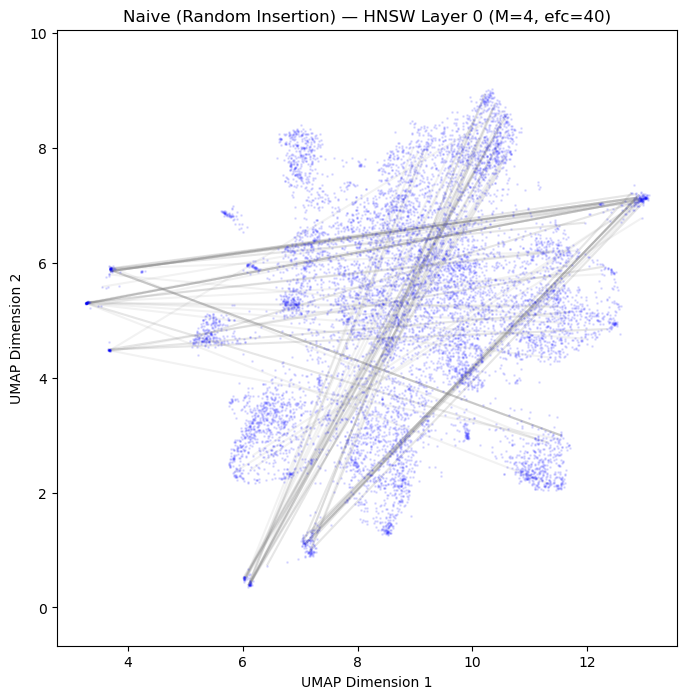

Plotting: Cluster-wise (Cluster-by-Cluster) — HNSW Layer 0 (M=4, efc=40)


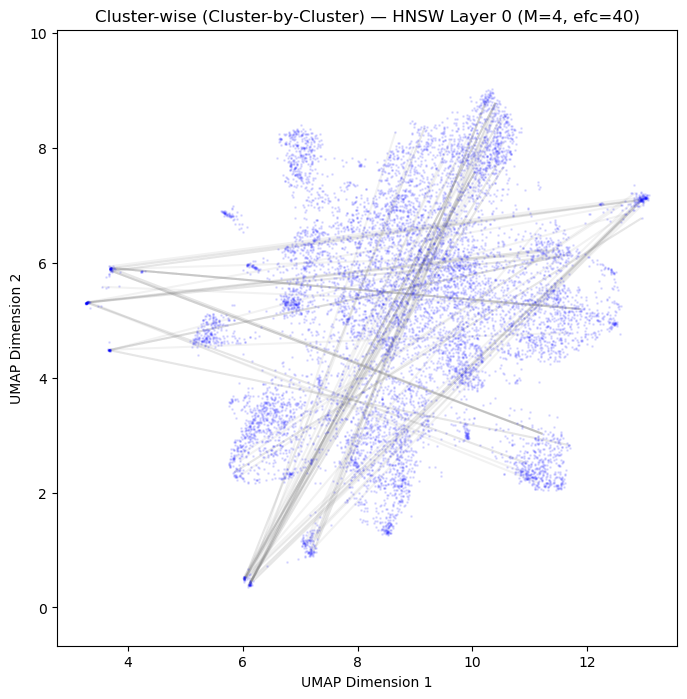

In [12]:
def plot_graph(coords, edges, title):
    """UMAP 좌표 위에 그래프(엣지+노드) 그리기."""
    print(f"Plotting: {title}")
    plt.figure(figsize=(8, 8))

    threshold = 8.0 # 이 임계값(e.g., 1.0)보다 긴 엣지만 그림 (조정 필요)
    # filter to draw edges which its length is longer than the threshold
    segments = [[coords[s], coords[t]] for (s, t) in edges]
    long_range_segments = []
    for start_node, end_node in segments:
        # 2D 좌표상의 유클리드 거리 계산
        dist = np.linalg.norm(start_node - end_node)

        # 거리가 threshold보다 긴 '장거리 지름길'만 추가
        if dist > threshold:
            long_range_segments.append([start_node, end_node])

    lc = LineCollection(long_range_segments, colors='gray', alpha=0.1, zorder=1)
    ax = plt.gca()
    ax.add_collection(lc)

    plt.scatter(coords[:, 0], coords[:, 1], s=1, c='blue', alpha=0.1, zorder=2)
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.axis('equal')
    plt.show()

plot_graph(coords_naive, edges_naive,
           f"Naive (Random Insertion) — HNSW Layer 0 (M={paramM}, efc={efConstruction})")
plot_graph(coords_clustered, edges_clustered,
           f"Cluster-wise (Cluster-by-Cluster) — HNSW Layer 0 (M={paramM}, efc={efConstruction})")

## Edge distance distribution

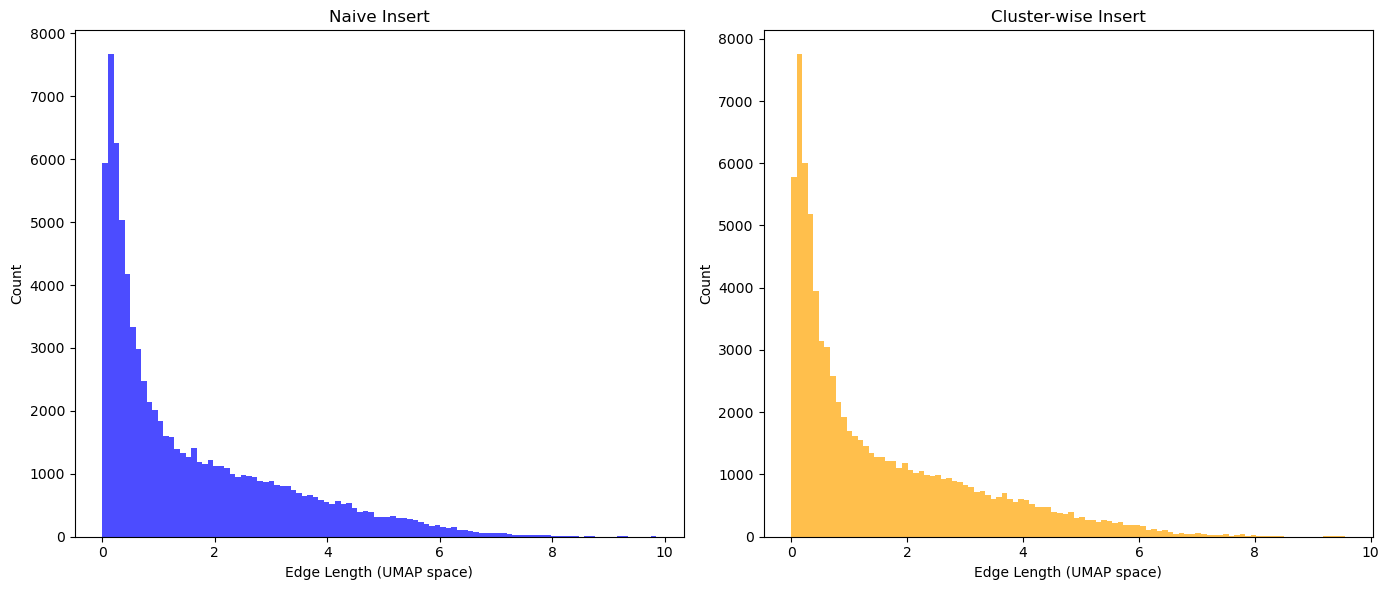

In [11]:
# For naive and clustered insert, want to compare the edge distance distribution
# Expect to see cluster-wise insert will have shorter edge length, meaning high locality

# edges_naive(coords_naive) vs edges_clustered(coords_clustered)
def compute_distance(coords, edges, result_list):
    segments = [[coords[s], coords[t]] for (s, t) in edges]
    for start_node, end_node in segments:
        dist = np.linalg.norm(start_node - end_node)
        result_list.append(dist)

naive_edge_distances = []
clustered_edge_distances = []

compute_distance(coords_naive, edges_naive, naive_edge_distances)
compute_distance(coords_clustered, edges_clustered, clustered_edge_distances)

# draw a plot for edge distance distribution
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(naive_edge_distances, bins=100, alpha=0.7, color='blue')
plt.xlabel("Edge Length (UMAP space)")
plt.ylabel("Count")
plt.title("Naive Insert")

plt.subplot(1, 2, 2)
plt.hist(clustered_edge_distances, bins=100, alpha=0.7, color='orange')
plt.xlabel("Edge Length (UMAP space)")
plt.ylabel("Count")
plt.title("Cluster-wise Insert")

plt.tight_layout()
plt.show()

In [18]:
# --- Long-bridge effectiveness check for HNSW (Faiss) ---
# Prereq: you already built FAISS HNSW indices `index_naive`, `index_clustered`
#         and have `train_norm` (L2-normalized vectors), `embedding_2d` (UMAP coords),
#         plus the insertion orders `naive_order`, `clustered_order`.
#         metric: cosine (FAISS IndexHNSWFlat with METRIC_INNER_PRODUCT on normalized vectors)

import numpy as np
import networkx as nx
from collections import defaultdict, Counter

# ---------- Utilities (extraction & mapping) ----------
def extract_layer0_edges(hnsw_index):
    """Extract (u_internal, v_internal) edges from FAISS HNSW layer-0."""
    offsets = faiss.vector_to_array(hnsw_index.hnsw.offsets)
    neighbors_flat = faiss.vector_to_array(hnsw_index.hnsw.neighbors)
    edges = []
    for i in range(len(offsets) - 1):
        s, e = offsets[i], offsets[i + 1]
        for nb in neighbors_flat[s:e]:
            if nb >= 0:
                edges.append((i, int(nb)))
    return edges

def to_undirected_edge_set_in_original_ids(edges_internal, order):
    """
    Convert internal-id edges to original sample ids.
    Return an undirected edge set {(min, max), ...}
    """
    order = np.asarray(order)
    s = set()
    for u, v in edges_internal:
        ou = int(order[u]); ov = int(order[v])
        if ou == ov:
            continue
        a, b = (ou, ov) if ou < ov else (ov, ou)
        s.add((a, b))
    return s

def build_nx_from_edge_set(edge_set, n_nodes):
    """Undirected NetworkX graph from edge set of original ids (0..n_nodes-1)."""
    G = nx.Graph()
    G.add_nodes_from(range(n_nodes))
    G.add_edges_from(edge_set)
    return G

# ---------- Communities & medoids ----------
def louvain_partition(G):
    """Community detection. Uses networkx's louvain_communities if available; otherwise greedy modularity."""
    try:
        from networkx.algorithms.community import louvain_communities
        comms = louvain_communities(G, seed=42, resolution=1.0)
    except Exception:
        from networkx.algorithms.community import greedy_modularity_communities
        comms = greedy_modularity_communities(G)
    # map node -> community id
    comm_id = {}
    for cid, C in enumerate(comms):
        for v in C:
            comm_id[v] = cid
    return comm_id, comms

def medoid_of_community(C, X):
    """Medoid index of nodes C (min sum of distances). X: normalized vectors (cosine metric)."""
    nodes = list(C)
    if len(nodes) == 0:
        return None
    # cosine distance on normalized -> 1 - dot
    sub = X[nodes]
    S = sub @ sub.T                # cosine similarity
    Dsum = (1.0 - S).sum(axis=1)   # sum of distances to others
    midx = int(np.argmin(Dsum))
    return nodes[midx]

# ---------- Distance / long-bridge labeling ----------
def cosine_dist(u, v, X):
    """Cosine distance on normalized vectors."""
    return 1.0 - float(np.dot(X[u], X[v]))

def compute_edge_lengths(edge_set, X):
    """Return array of cosine distances for edges (u,v) w.r.t. normalized X."""
    dists = []
    for (u, v) in edge_set:
        dists.append(cosine_dist(u, v, X))
    return np.asarray(dists)

def label_long_bridges(edge_set, comm_id, X, length_quantile=0.7):
    """
    Long bridge = inter-community edge AND distance > global quantile threshold.
    Returns: long_bridge_set (subset of edge_set), threshold value
    """
    dists = compute_edge_lengths(edge_set, X)
    tau = np.quantile(dists, length_quantile)
    LB = set()
    for (u, v), d in zip(edge_set, dists):
        if comm_id.get(u, -1) != comm_id.get(v, -1) and d >= tau:
            LB.add((u, v))
    return LB, float(tau)

# ---------- Greedy walk usage of long-bridges ----------
def neighbors_of(G, v):
    return list(G.adj[v])

def greedy_walk_used_long_bridge(G, X, q_vec, start_v, long_bridge_set, max_steps=60, first_T=20):
    """
    Greedy walk on layer-0 from start_v towards query vector q_vec:
    - each step pick neighbor with smallest dist to q_vec
    - stop if no improvement
    - return whether a long-bridge edge was used within the first_T steps and list of traversed edges
    """
    used_long = False
    traversed = []
    cur = start_v
    best_d = 1.0 - float(np.dot(X[cur], q_vec))  # cosine distance (normalized)
    for step in range(max_steps):
        nbrs = neighbors_of(G, cur)
        if not nbrs:
            break
        # choose neighbor minimizing distance to query
        cand_dists = [1.0 - float(np.dot(X[n], q_vec)) for n in nbrs]
        idx = int(np.argmin(cand_dists))
        nxt, nxt_d = nbrs[idx], cand_dists[idx]
        if nxt_d >= best_d - 1e-9:   # no improvement
            break
        # record edge
        a, b = (cur, nxt) if cur < nxt else (nxt, cur)
        traversed.append((a, b))
        if step < first_T and (a, b) in long_bridge_set:
            used_long = True
        cur, best_d = nxt, nxt_d
    return used_long, traversed

def hub_nodes(G, top_k=64):
    """Top-degree nodes as hubs; used as probable good starts."""
    degs = G.degree()
    top = sorted(degs, key=lambda x: x[1], reverse=True)[:top_k]
    return [v for v, _ in top]

def used_long_bridge_ratio(G, X, long_bridge_set, Q, starts, first_T=20, max_steps=60):
    """
    For a set of query vectors Q and list of start nodes,
    run greedy walk and compute ratio of walks that used a long-bridge within first_T steps.
    """
    used = 0; total = 0
    for i, q in enumerate(Q):
        s = starts[i % len(starts)]  # cycle starts
        flag, _ = greedy_walk_used_long_bridge(G, X, q, s, long_bridge_set,
                                               max_steps=max_steps, first_T=first_T)
        used += int(flag); total += 1
    return (used / max(total, 1)), used, total

# ---------- Medoid-to-medoid shortest path (global bridge quality) ----------
def mean_shortest_path_between_medoids(G, comms, X, sample_max=100):
    """Pick medoids of communities; compute mean shortest path length among a random subset of medoid pairs."""
    medoids = []
    for C in comms:
        m = medoid_of_community(C, X)
        if m is not None:
            medoids.append(m)
    if len(medoids) < 2:
        return np.nan
    # sample pairs if too many
    pairs = []
    for i in range(len(medoids)):
        for j in range(i+1, len(medoids)):
            pairs.append((medoids[i], medoids[j]))
    if len(pairs) > sample_max:
        rng = np.random.default_rng(42)
        pairs = rng.choice(pairs, size=sample_max, replace=False)
    # BFS shortest path length on unweighted G
    lens = []
    for u, v in pairs:
        try:
            l = nx.shortest_path_length(G, u, v)
            lens.append(l)
        except nx.NetworkXNoPath:
            lens.append(np.inf)
    return float(np.mean(lens))

# =====================================================================
# 0) 준비: 두 인덱스의 layer-0 edge set (원본 id)와 그래프 만들기
edges_naive_int      = extract_layer0_edges(index_naive)
edges_clustered_int  = extract_layer0_edges(index_clustered)

edge_set_naive     = to_undirected_edge_set_in_original_ids(edges_naive_int,     naive_order)
edge_set_clustered = to_undirected_edge_set_in_original_ids(edges_clustered_int, clustered_order)

G_naive     = build_nx_from_edge_set(edge_set_naive,     n_nodes=len(train_norm))
G_clustered = build_nx_from_edge_set(edge_set_clustered, n_nodes=len(train_norm))

# 1) 커뮤니티 분할
comm_id_naive,     comms_naive     = louvain_partition(G_naive)
comm_id_clustered, comms_clustered = louvain_partition(G_clustered)

# 2) inter-cluster edge ratio
def inter_cluster_ratio(edge_set, comm_id):
    cnt_ic, cnt_all = 0, 0
    for (u,v) in edge_set:
        cnt_all += 1
        if comm_id.get(u,-1) != comm_id.get(v,-1):
            cnt_ic += 1
    return cnt_ic / max(cnt_all,1)

icr_naive     = inter_cluster_ratio(edge_set_naive,     comm_id_naive)
icr_clustered = inter_cluster_ratio(edge_set_clustered, comm_id_clustered)

print(f"[Inter-cluster edge ratio] naive={icr_naive:.4f}, clustered={icr_clustered:.4f}")

# 3) 롱브리지 라벨링 (cosine 거리의 상위 q분위수 + inter-cluster)
LB_naive, tau_n     = label_long_bridges(edge_set_naive,     comm_id_naive,     train_norm, length_quantile=0.7)
LB_clustered, tau_c = label_long_bridges(edge_set_clustered, comm_id_clustered, train_norm, length_quantile=0.7)

print(f"[Long-bridge τ (cosine dist) quantile=0.7] naive τ={tau_n:.4f}, clustered τ={tau_c:.4f}")
print(f"  #LB naive={len(LB_naive)} / {len(edge_set_naive)}, clustered={len(LB_clustered)} / {len(edge_set_clustered)}")

# 4) medoid-to-medoid 평균 최단 경로 길이
msp_naive     = mean_shortest_path_between_medoids(G_naive,     comms_naive,     train_norm, sample_max=200)
msp_clustered = mean_shortest_path_between_medoids(G_clustered, comms_clustered, train_norm, sample_max=200)
print(f"[Medoid-to-medoid mean shortest path] naive={msp_naive:.2f}, clustered={msp_clustered:.2f}")

# 5) 탐색에서 롱브리지 사용 비율 (greedy walk proxy)
#    쿼리는 test에서 일부 샘플(Q), 시작점은 각 그래프의 허브 노드(top degree) 집합
Q = test[:300]  # 300개만
starts_naive     = hub_nodes(G_naive,     top_k=10)
starts_clustered = hub_nodes(G_clustered, top_k=10)

ratio_n, used_n, total_n = used_long_bridge_ratio(G_naive,     train_norm, LB_naive,     Q, starts_naive,     first_T=20, max_steps=60)
ratio_c, used_c, total_c = used_long_bridge_ratio(G_clustered, train_norm, LB_clustered, Q, starts_clustered, first_T=20, max_steps=60)
print(f"[Used long-bridge within first 20 steps] naive={ratio_n:.3f} ({used_n}/{total_n}), "
      f"clustered={ratio_c:.3f} ({used_c}/{total_c})")

[Inter-cluster edge ratio] naive=0.4133, clustered=0.4022
[Long-bridge τ (cosine dist) quantile=0.7] naive τ=0.7489, clustered τ=0.7487
  #LB naive=9119 / 57166, clustered=9182 / 56842
[Medoid-to-medoid mean shortest path] naive=2.98, clustered=2.93
[Used long-bridge within first 20 steps] naive=0.130 (39/300), clustered=0.097 (29/300)
